In [22]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm
hue_order = ['low','medium','high','critical']

## Load data and filter on which images to analyze

In [23]:
candidates_3000 = pd.read_csv('../data/considered_3000_images.csv')

In [24]:
affected = pd.read_csv('../data/vulnerable_packages_today.csv')
# Please ask permission from Snyk to have this dataset 
affected.package.fillna('nan', inplace=True)
affected['last_updated'] = pd.to_datetime(affected['last_updated'])
affected['disclosed'] = pd.to_datetime(affected['disclosed'])
affected['base'] = affected['base'].replace(d)
mask  = affected.image.isin(candidates_3000.image)
affected = affected[mask]
affected.drop_duplicates(inplace=True)

affected.shape

(42504, 16)

In [25]:
affected.image.unique().size

2814

In [26]:
# only added packages 
added_packages = affected.query('core == False')

## Let's compare disclosure date with the last_update date

In [27]:
len(affected)

42504

#### Basic description

In [28]:
affected.id.unique().size

632

In [29]:
affected[['id','base','severity']].drop_duplicates().groupby('base').count()[['id']]

,id
base,
Python,152
Ruby,208
node,272


In [30]:
affected[['id','severity','base']].drop_duplicates().groupby(['severity','base']).count()

id
severity base       
critical Python   13
         Ruby     10
         node     20
high     Python   57
         Ruby     78
         node    110
low      Python    8
         Ruby      6
         node     25
medium   Python   74
         Ruby    114
         node    117

In [31]:
affected[['id','severity']].drop_duplicates().groupby(['severity']).count()

,id
severity,
critical,43
high,245
low,39
medium,305


In [32]:
len(affected[['base','package']].drop_duplicates())

317

In [33]:
affected[['base','package']].drop_duplicates().groupby('base').count()[['package']]

,package
base,
Python,65
Ruby,94
node,158


In [34]:
len(affected[['base','package','version_today']].drop_duplicates())

1442

In [35]:
affected[['base','package','version_today']].drop_duplicates().groupby('base').count()[['package']]

,package
base,
Python,325
Ruby,555
node,562


In [36]:
affected.image.unique().size

2814

In [37]:
affected[['image','base']].drop_duplicates().groupby('base').count()[['image']]

,image
base,
Python,814
Ruby,1000
node,1000


In [38]:
# Types of vulnerabilities affecting Docker images
affected.vuln_name.unique().size

125

In [48]:
# How many images suffering from which packages
tmp = (affected[['image','base','vuln_name']]
 .drop_duplicates()
 .groupby(['base','vuln_name'])
 .count()
 .sort_values('image', ascending=False)
 .groupby(['base'])
 .head(3)
 .reset_index()
)
tmp


,base,vuln_name,image
0,node,Prototype Pollution,1000
1,node,Arbitrary File Overwrite,997
2,Ruby,Arbitrary Code Injection,996
3,Ruby,Arbitrary Code Execution,996
4,node,Arbitrary File Write,995
5,Ruby,Denial of Service (DoS),946
6,Python,Denial of Service (DoS),393
7,Python,Information Exposure,270
8,Python,Insufficient Randomness,217


In [51]:
# How many images suffering from which packages
(affected[affected.vuln_name.isin(tmp.vuln_name)]
 [['package','base','vuln_name']]
 .drop_duplicates()
 .groupby(['base','vuln_name'])
 .count()
 .sort_values('package', ascending=False)
 .groupby(['base'])
 .head(10)
)

package
base   vuln_name                        
node   Prototype Pollution            17
       Denial of Service (DoS)        15
Python Denial of Service (DoS)        14
Ruby   Denial of Service (DoS)        13
       Information Exposure           10
Python Information Exposure            8
       Arbitrary Code Execution        7
node   Arbitrary Code Execution        6
       Arbitrary File Overwrite        6
       Information Exposure            6
Ruby   Arbitrary Code Execution        5
       Arbitrary Code Injection        5
node   Arbitrary Code Injection        5
Ruby   Prototype Pollution             3
node   Arbitrary File Write            3
Python Arbitrary Code Injection        2
       Insufficient Randomness         1
Ruby   Arbitrary File Write            1
Python Arbitrary File Overwrite        1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


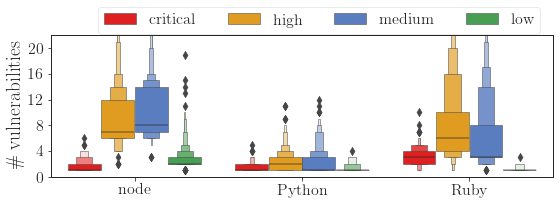

In [20]:
tmp_df = affected.groupby(['image','severity','base']).count()[['package']].reset_index()
ax = sns.boxenplot(x="base", 
                   y="package",
                   hue='severity',
                   hue_order = reversed(hue_order),
                   order = order,
                   data=tmp_df,
                   palette=[colors[r] for r in reversed(['up-to-date','patch','minor','major'])] , 
                    linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\# vulnerabilities',
    ylim=(0,22),
)
ax.figure.set_size_inches(9,2.6)
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (0.99, 1.26))

plt.yticks(pd.np.arange(0, 22, 4)) 

In [41]:
# Median number of vulnerabilities in images
(affected.groupby(['base','image'])
 .count()
 .groupby('base')['package']
 .describe()
)

,count,mean,std,min,25%,50%,75%,max
base,,,,,,,,
Python,814.0,3.313268,3.565089,1.0,1.0,2.0,4.0,22.0
Ruby,1000.0,17.163000,11.793707,1.0,9.0,14.0,20.0,72.0
node,1000.0,22.644000,12.920534,3.0,15.0,19.0,28.0,155.0


In [42]:
# Mann Whitney U test
tmp = affected.groupby(['base','image']).count()[['id']].reset_index()
print(scipy.stats.mannwhitneyu(tmp.query('base == "node"').id, tmp.query('base == "Ruby"').id))
print(scipy.stats.mannwhitneyu(tmp.query('base == "node"').id, tmp.query('base == "Python"').id))
print(scipy.stats.mannwhitneyu(tmp.query('base == "Python"').id, tmp.query('base == "Ruby"').id))

MannwhitneyuResult(statistic=314021.5, pvalue=1.8031273027599202e-47)
MannwhitneyuResult(statistic=12224.5, pvalue=6.183842736865965e-280)
MannwhitneyuResult(statistic=47878.5, pvalue=7.261707834797108e-232)


In [43]:
# Effect size
tmp = affected.groupby(['base','image']).count()[['id']].reset_index()
print(effect_size.cliffsDelta(tmp.query('base == "node"').id, tmp.query('base == "Ruby"').id))
print(effect_size.cliffsDelta(tmp.query('base == "node"').id, tmp.query('base == "Python"').id))
print(effect_size.cliffsDelta(tmp.query('base == "Python"').id, tmp.query('base == "Ruby"').id))


d=0.371957
True
d=0.9699643734643735
True
d=-0.8823624078624078
True


### Let's check whether core packages have less vulnerabilities

In [69]:
print(len(affected.query('core==False')), len(affected.query('core==True')))
# Number of unique vuls affecting packages
(affected[['base','core','id']]
 .drop_duplicates()
 .groupby(['base','core'])
 .count()
)

21083 21421


id
base   core      
Python False  152
Ruby   False  205
       True     8
node   False  234
       True    38

In [70]:
print(affected.query('core==False').package.unique().size, affected.query('core==True').package.unique().size)
(affected[['base','package','core']]
 .drop_duplicates()
 .groupby(['base','core'])
 .count()
)

287 31


package
base   core          
Python False       65
Ruby   False       91
       True         5
node   False      132
       True        26

In [72]:
len(affected), len(affected.query('need_update == True'))

(42504, 33624)

In [77]:
for x in order:
    print(x, len(affected.query('need_update == True and base=="'+x+'"'))*100/len(affected.query('base=="'+x+'"')))

node 86.77795442501325
Python 63.99703374119392
Ruby 71.36281535862028


In [39]:
affected.query('need_update == True').id.unique().size

484

# Let's check the types of vulnerabilities and how many images they have them

In [58]:
tmp = affected[['image','base','vuln_name']].drop_duplicates()
tmp = tmp.groupby(['image','base']).count().reset_index()
tmp = tmp.groupby(['vuln_name','base']).count().reset_index().sort_values('image')
tmp['image_cumsum'] = tmp.groupby('base')['image'].cumsum()
tmp.sort_values('vuln_name', inplace=True)
tmp['vuln_name_cumsum'] = tmp.groupby('base')['vuln_name'].cumsum()

tmp

,vuln_name,base,image,image_cumsum,vuln_name_cumsum
0,1,Python,334,814,1
2,1,node,1,6,1
1,1,Ruby,1,3,1
4,2,Ruby,12,49,3
3,2,Python,164,480,3
...,...,...,...,...,...
61,27,Ruby,1,2,378
63,28,Ruby,1,5,406
64,29,Ruby,1,4,435
65,30,node,1,2,323


In [62]:
affected.query('base == "Ruby"').id.unique().size

208

## Ignore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


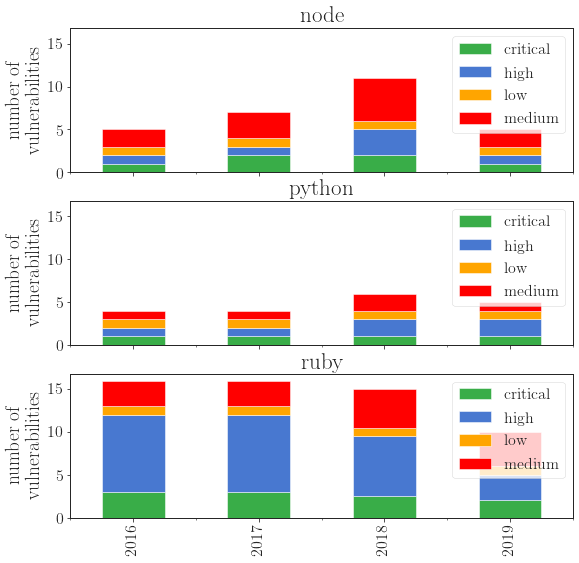

In [102]:
# Onlye core packages
added_packages['year'] = added_packages['last_updated'].apply(lambda x: x.year)
tmp_df = (added_packages
          .groupby(['image','severity','base','year'])
          .count()[['package']]
          .reset_index()
         )

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    df_ = (tmp_df.query('base == "'+base+'"')
     .groupby(['year','severity'])['package']
     .describe()[['50%']]
           .rename(columns={'50%':'median'})
     .reset_index())
    
    df_ = (df_
     .pivot_table(index=['year'], columns='severity', values='median')
    )

    ax = df_.plot.bar(stacked=True,  color = [colors[r] for r in ['up-to-date','patch','minor','major']], ax=axes[i])
    ax.set(
        xlabel='',
        ylabel='number of \nvulnerabilities',
        title=base,
        #ylim=(0,200),
    )
    ax.legend(ncol=1, loc='upper right', prop={'size': 16, 'weight':'bold'})

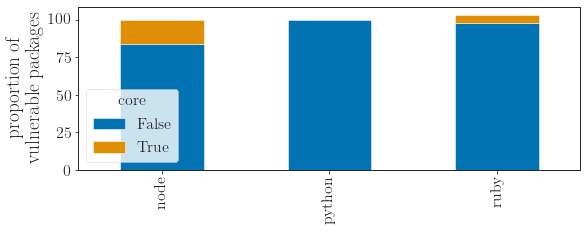

In [103]:
#Which packages are more vulnerable
tmp = affected[['base','package','core']].drop_duplicates().groupby(['base','core']).count()*100/affected[['base','package']].drop_duplicates().groupby(['base']).count()
#tmp.drop('id', axis=1, inplace=True)
tmp = (tmp
       .reset_index()
 .pivot_table(index=['base'], columns='core', values='package')
 .reset_index()
 .set_index('base')
)

ax = tmp.plot.bar(stacked=True)
ax.set(
    xlabel='',
    ylabel='proportion of \n vulnerable packages'    #ylim=(0,200),
)
ax.figure.set_size_inches(9,3)
